In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [430]:
train['Income'].value_counts()[:50].values

array([8697,  743,  550,  547,  526,  401,  389,  342,  281,  245,  239,
        226,  208,  206,  202,  200,  163,  153,  147,  147,  143,  111,
        110,  107,  105,  103,   95,   85,   77,   75,   66,   61,   54,
         53,   53,   49,   47,   45,   42,   40,   37,   36,   30,   28,
         27,   27,   27,   26,   24,   24], dtype=int64)

<Axes: ylabel='Frequency'>

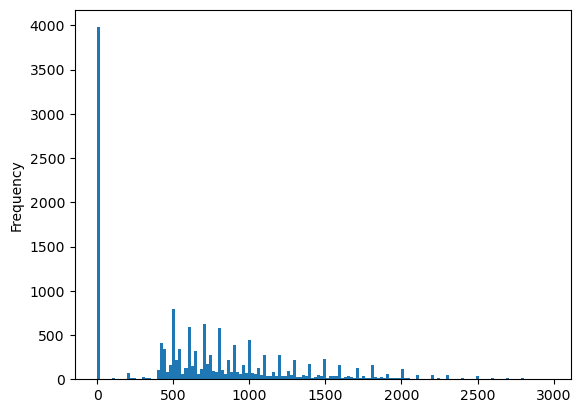

In [237]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
train = train[train['Age'] > 14]
train = train[train['Employment_Status'] != 'Not Working']
train = train[train['Industry_Status'] != 'Not in universe or children']
train[train['Income'] < 3000]['Income'].plot.hist(bins=150)

In [266]:
train

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,41,M,High graduate,Full-Time,52,Retail,Sales,White,All other,Separated,...,Native,US,US,US,Single,0,0,0,Under Median,900
19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Under Median,1300
19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,Single,...,Native,US,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850
19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Unknown,999


Children or Armed Forces         477
Full-Time                        342
Choice Part-Time                  29
Part-Time (Usually Part-Time)      5
Part-Time (Usually Full-Time)      3
Seeking Full-Time                  3
Seeking Part-Time                  3
Not Working                        0
Name: Employment_Status, dtype: int64

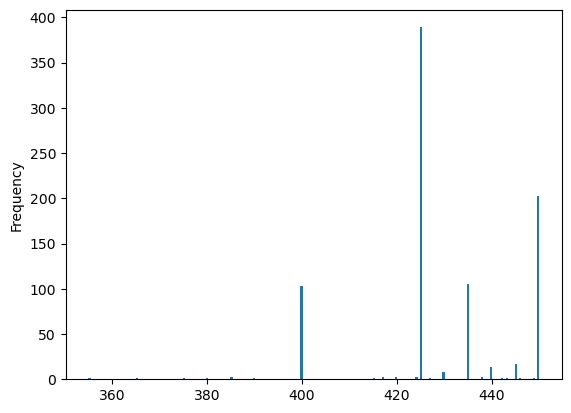

In [29]:
s = 350
e = s + 100
train[(train['Income'] > s) & (train['Income'] <= e)]['Income'].plot.hist(bins=200)
train[(train['Income'] > s) & (train['Income'] <= e)]['Employment_Status'].value_counts()

In [33]:
train[train['Income'] == 425]

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Hispanic_Origin,Martial_Status,Household_Status,...,Industry_Status_encoded,Occupation_Status_encoded,Hispanic_Origin_encoded,Martial_Status_encoded,Household_Status_encoded,Birth_Country_encoded,Birth_Country (Father)_encoded,Birth_Country (Mother)_encoded,Tax_Status_encoded,Income_Status_encoded
0,63,M,Middle (7-8),Full-Time,4,Social Services,Services,All other,Married,Householder,...,608.765668,512.062257,574.993697,687.201172,728.328241,560.650659,574.009177,571.103049,60.947341,545.810820
63,27,F,High graduate,Children or Armed Forces,52,Retail,Sales,All other,Married,Spouse of householder,...,527.744681,488.010638,574.993697,687.201172,620.124322,560.650659,574.009177,571.103049,742.472403,545.810820
173,67,F,High graduate,Full-Time,52,Retail,Sales,All other,Married,Spouse of householder,...,527.744681,488.010638,574.993697,687.201172,620.124322,560.650659,574.009177,571.103049,203.144989,537.030294
212,17,M,High Senior,Full-Time,0,Personal Services (except Private Household),Services,All other,Single,Child <18 never marr not in subfamily,...,473.620047,512.062257,574.993697,368.479404,63.779775,560.650659,574.009177,571.103049,60.947341,537.030294
296,20,M,High Sophomore,Choice Part-Time,12,Retail,Sales,Mexican-American,Single,Child 18+ never marr Not in a subfamily,...,527.744681,488.010638,420.946483,368.479404,505.561828,560.650659,574.009177,571.103049,60.947341,537.030294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19742,59,F,Elementary (5-6),Full-Time,5,Personal Services (except Private Household),Services,Mexican-American,Married,Spouse of householder,...,473.620047,512.062257,420.946483,687.201172,620.124322,560.650659,574.009177,571.103049,60.947341,537.030294
19796,25,M,College,Children or Armed Forces,40,Retail,Sales,All other,Single,Child 18+ never marr Not in a subfamily,...,527.744681,488.010638,574.993697,368.479404,505.561828,560.650659,574.009177,571.103049,615.808365,537.030294
19906,21,F,College,Full-Time,20,Retail,Services,Mexican-American,Married,Householder,...,527.744681,512.062257,420.946483,687.201172,728.328241,560.650659,381.119527,571.103049,742.472403,545.810820
19931,19,F,College,Children or Armed Forces,28,Retail,Services,All other,Single,Other Rel 18+ never marr not in subfamily,...,527.744681,512.062257,574.993697,368.479404,398.989744,560.650659,574.009177,571.103049,615.808365,545.810820


In [284]:
s = 2000
e = s + 100
train[(train['Income'] > s) & (train['Income'] <= e)].loc[:,['Age','Income']].mean()

Age         38.263158
Income    2076.578947
dtype: float64

In [6]:
# train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
# test = pd.read_csv('./open/test.csv').drop('ID',axis=1)

# for column in tqdm(train.columns):
#     if train[column].dtype == 'object' and train[column].nunique() <= 4:  # 가짓수가 4 이상인 경우
#         encoded = pd.get_dummies(train[column], prefix=column)
#         train = pd.concat([train.drop(column, axis=1), encoded], axis=1)

# train

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 162.50it/s]


,Age,Gender,Working_Week (Yearly),Gains,Losses,Dividends,Income_Status,Income,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),...,Birth_Country (Mother)_US,Birth_Country (Mother)_Unknown,Birth_Country (Mother)_Vietnam,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single
0,63,M,4,0,0,0,Unknown,425,0,0,...,1,0,0,0,0,0,0,0,1,0
1,37,M,52,0,0,0,Under Median,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,58,F,52,3411,0,0,Under Median,860,0,0,...,1,0,0,0,0,0,1,0,0,0
3,44,M,52,0,0,0,Under Median,850,0,0,...,1,0,0,0,0,0,0,0,0,1
4,37,F,52,0,0,0,Unknown,570,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,M,52,0,0,0,Under Median,1300,0,0,...,1,0,0,0,0,0,0,0,0,1
19996,20,F,12,0,0,0,Under Median,850,0,0,...,0,0,0,0,0,0,0,0,1,0
19997,22,M,52,0,0,0,Unknown,999,0,0,...,1,0,0,0,0,0,0,0,0,1
19998,76,F,0,0,0,0,Under Median,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [382]:
from pycaret.regression import *

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# object_columns = train.select_dtypes(include=['object']).columns
# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Income'] > 0)]
data = data.drop('ID',axis=1)
# PyCaret 회귀 모델 설정
regression_setup = setup(data, target='Income',
                         max_encoding_ohe=2,
                         train_size=0.8,
                         fold=10,
                         session_id=42)

# 다양한 회귀 모델 비교
best_model = compare_models(n_select=3, sort='RMSE')

,Description,Value
0,Session id,42
1,Target,Income
2,Target type,Regression
3,Original data shape,"(11145, 22)"
4,Transformed data shape,"(11145, 22)"
5,Transformed train set shape,"(8916, 22)"
6,Transformed test set shape,"(2229, 22)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,245.3501,116540.8445,341.1393,0.4830,0.3453,0.3015,0.1380
gbr,Gradient Boosting Regressor,247.8585,116648.9367,341.2743,0.4825,0.3484,0.3070,0.3120
catboost,CatBoost Regressor,246.1275,117163.0712,342.0395,0.4803,0.3463,0.3018,1.1970
rf,Random Forest Regressor,255.7584,124433.9414,352.4927,0.4478,0.3581,0.3171,0.7710
xgboost,Extreme Gradient Boosting,254.6904,124953.4822,353.2407,0.4457,0.3581,0.3118,0.3330
lr,Linear Regression,269.2051,128653.5888,358.3658,0.4295,0.3818,0.3395,0.6470
ridge,Ridge Regression,269.2051,128653.6226,358.3658,0.4295,0.3818,0.3395,0.1050
lasso,Lasso Regression,269.2111,128660.6103,358.3749,0.4295,0.3816,0.3395,0.1070
llar,Lasso Least Angle Regression,269.2111,128660.6274,358.3749,0.4295,0.3816,0.3395,0.0990
lar,Least Angle Regression,269.2638,128685.2041,358.4103,0.4294,0.3820,0.3396,0.1000


In [127]:
train.columns

Index(['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [ ]:
# feaature engineering

In [20]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    return train, test

train, test = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    # 교차 검증 설정 (5-Fold 교차 검증 사용)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]

        # LightGBM 모델 정의
        model = lgb.LGBMRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-03-28 12:19:53,358] A new study created in memory with name: no-name-d70e6282-ecf8-4dba-9642-85fce5ee9c98
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9614954944855665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614954944855665
[LightGBM] [Warning] bagging_fraction is set=0.6814954719124637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814954719124637
[LightGBM] [Warning] lambda_l1 is set=6.941656178959216e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.941656178959216e-08
[LightGBM] [Warning] lambda_l2 is set=0.02156751067147791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02156751067147791
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:20:11,833] Trial 0 finished with value: 510.5015229459042 and parameters: {'lambda_l1': 6.941656178959216e-08, 'lambda_l2': 0.02156751067147791, 'num_leaves': 173, 'learning_rate': 0.008434631838839983, 'feature_fraction': 0.9614954944855665, 'bagging_fraction': 0.6814954719124637, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 0 with value: 510.5015229459042.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6608178109937505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608178109937505
[LightGBM] [Warning] bagging_fraction is set=0.5985639174078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985639174078462
[LightGBM] [Warning] lambda_l1 is set=0.21851134535042638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21851134535042638
[LightGBM] [Warning] lambda_l2 is set=3.6784087709205204e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6784087709205204e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:20:21,123] Trial 1 finished with value: 592.6355402879102 and parameters: {'lambda_l1': 0.21851134535042638, 'lambda_l2': 3.6784087709205204e-07, 'num_leaves': 54, 'learning_rate': 3.1111241628073803e-06, 'feature_fraction': 0.6608178109937505, 'bagging_fraction': 0.5985639174078462, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 0 with value: 510.5015229459042.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.735974442647896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735974442647896
[LightGBM] [Warning] bagging_fraction is set=0.613036244891588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.613036244891588
[LightGBM] [Warning] lambda_l1 is set=0.00019476270902811868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019476270902811868
[LightGBM] [Warning] lambda_l2 is set=7.128996446587197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.128996446587197e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-28 12:20:34,936] Trial 2 finished with value: 504.75111036249183 and parameters: {'lambda_l1': 0.00019476270902811868, 'lambda_l2': 7.128996446587197e-08, 'num_leaves': 205, 'learning_rate': 0.8263595382557334, 'feature_fraction': 0.735974442647896, 'bagging_fraction': 0.613036244891588, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 2 with value: 504.75111036249183.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.937922083675789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937922083675789
[LightGBM] [Warning] bagging_fraction is set=0.5797724615266963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797724615266963
[LightGBM] [Warning] lambda_l1 is set=0.004908792247022148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004908792247022148
[LightGBM] [Warning] lambda_l2 is set=0.0052767805655833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0052767805655833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:20:44,986] Trial 3 finished with value: 486.71751495832723 and parameters: {'lambda_l1': 0.004908792247022148, 'lambda_l2': 0.0052767805655833, 'num_leaves': 57, 'learning_rate': 0.030210180061204406, 'feature_fraction': 0.937922083675789, 'bagging_fraction': 0.5797724615266963, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9966769259433662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9966769259433662
[LightGBM] [Warning] bagging_fraction is set=0.5893032177895617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5893032177895617
[LightGBM] [Warning] lambda_l1 is set=2.2158126084530135e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2158126084530135e-08
[LightGBM] [Warning] lambda_l2 is set=0.004199888169582362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004199888169582362
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:21:05,516] Trial 4 finished with value: 592.681741595062 and parameters: {'lambda_l1': 2.2158126084530135e-08, 'lambda_l2': 0.004199888169582362, 'num_leaves': 223, 'learning_rate': 4.100029997791846e-07, 'feature_fraction': 0.9966769259433662, 'bagging_fraction': 0.5893032177895617, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.54821855452199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54821855452199
[LightGBM] [Warning] bagging_fraction is set=0.9246194284870919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246194284870919
[LightGBM] [Warning] lambda_l1 is set=0.005211050022376767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005211050022376767
[LightGBM] [Warning] lambda_l2 is set=0.0038279607036613927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038279607036613927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:21:29,616] Trial 5 finished with value: 497.1465982290697 and parameters: {'lambda_l1': 0.005211050022376767, 'lambda_l2': 0.0038279607036613927, 'num_leaves': 235, 'learning_rate': 0.5374604526626239, 'feature_fraction': 0.54821855452199, 'bagging_fraction': 0.9246194284870919, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41347322556400234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41347322556400234
[LightGBM] [Warning] bagging_fraction is set=0.6761091171207805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6761091171207805
[LightGBM] [Warning] lambda_l1 is set=6.632631133434424e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.632631133434424e-07
[LightGBM] [Warning] lambda_l2 is set=1.2839369821198734e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2839369821198734e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:21:43,056] Trial 6 finished with value: 592.6890374906577 and parameters: {'lambda_l1': 6.632631133434424e-07, 'lambda_l2': 1.2839369821198734e-06, 'num_leaves': 245, 'learning_rate': 2.1064082436260398e-08, 'feature_fraction': 0.41347322556400234, 'bagging_fraction': 0.6761091171207805, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8233235032224993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8233235032224993
[LightGBM] [Warning] bagging_fraction is set=0.8702282989394121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702282989394121
[LightGBM] [Warning] lambda_l1 is set=0.4052439670397602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4052439670397602
[LightGBM] [Warning] lambda_l2 is set=1.257523512863685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.257523512863685e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:21:55,605] Trial 7 finished with value: 592.6466781612114 and parameters: {'lambda_l1': 0.4052439670397602, 'lambda_l2': 1.257523512863685e-08, 'num_leaves': 246, 'learning_rate': 2.3990225094243767e-06, 'feature_fraction': 0.8233235032224993, 'bagging_fraction': 0.8702282989394121, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6435066389306151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435066389306151
[LightGBM] [Warning] bagging_fraction is set=0.4935460266415618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935460266415618
[LightGBM] [Warning] lambda_l1 is set=2.0450567373433097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0450567373433097
[LightGBM] [Warning] lambda_l2 is set=0.38268653355032006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38268653355032006
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:22:13,902] Trial 8 finished with value: 589.7904250299041 and parameters: {'lambda_l1': 2.0450567373433097, 'lambda_l2': 0.38268653355032006, 'num_leaves': 215, 'learning_rate': 0.00016665144639474132, 'feature_fraction': 0.6435066389306151, 'bagging_fraction': 0.4935460266415618, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5111246139209166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111246139209166
[LightGBM] [Warning] bagging_fraction is set=0.5776485960588857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776485960588857
[LightGBM] [Warning] lambda_l1 is set=2.693268360335575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.693268360335575e-07
[LightGBM] [Warning] lambda_l2 is set=0.0070730066057711795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0070730066057711795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-28 12:22:23,489] Trial 9 finished with value: 513.4091632665459 and parameters: {'lambda_l1': 2.693268360335575e-07, 'lambda_l2': 0.0070730066057711795, 'num_leaves': 116, 'learning_rate': 0.008736154484948463, 'feature_fraction': 0.5111246139209166, 'bagging_fraction': 0.5776485960588857, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8636216089981871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636216089981871
[LightGBM] [Warning] bagging_fraction is set=0.4089473442052991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4089473442052991
[LightGBM] [Warning] lambda_l1 is set=7.840630029651515e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840630029651515e-05
[LightGBM] [Warning] lambda_l2 is set=9.937001119896996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.937001119896996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:22:28,054] Trial 10 finished with value: 543.8274882282992 and parameters: {'lambda_l1': 7.840630029651515e-05, 'lambda_l2': 9.937001119896996, 'num_leaves': 10, 'learning_rate': 0.0042673760001046565, 'feature_fraction': 0.8636216089981871, 'bagging_fraction': 0.4089473442052991, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5749085331984479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749085331984479
[LightGBM] [Warning] bagging_fraction is set=0.9533779417021031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533779417021031
[LightGBM] [Warning] lambda_l1 is set=0.013144851213058134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013144851213058134
[LightGBM] [Warning] lambda_l2 is set=3.305613001511703e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.305613001511703e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:22:42,398] Trial 11 finished with value: 503.8574968462275 and parameters: {'lambda_l1': 0.013144851213058134, 'lambda_l2': 3.305613001511703e-05, 'num_leaves': 104, 'learning_rate': 0.9606894334142427, 'feature_fraction': 0.5749085331984479, 'bagging_fraction': 0.9533779417021031, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 3 with value: 486.71751495832723.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49824835412334356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49824835412334356
[LightGBM] [Warning] bagging_fraction is set=0.8080539286002333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080539286002333
[LightGBM] [Warning] lambda_l1 is set=0.006441647495019288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006441647495019288
[LightGBM] [Warning] lambda_l2 is set=0.00010188115150503333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010188115150503333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:22:53,852] Trial 12 finished with value: 484.74924420200557 and parameters: {'lambda_l1': 0.006441647495019288, 'lambda_l2': 0.00010188115150503333, 'num_leaves': 70, 'learning_rate': 0.05853686961238014, 'feature_fraction': 0.49824835412334356, 'bagging_fraction': 0.8080539286002333, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 12 with value: 484.74924420200557.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4077971972835399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4077971972835399
[LightGBM] [Warning] bagging_fraction is set=0.8031153892562005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031153892562005
[LightGBM] [Warning] lambda_l1 is set=1.2790472692290887e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2790472692290887e-05
[LightGBM] [Warning] lambda_l2 is set=8.366424638637706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366424638637706e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:23:04,888] Trial 13 finished with value: 585.9812462848987 and parameters: {'lambda_l1': 1.2790472692290887e-05, 'lambda_l2': 8.366424638637706e-05, 'num_leaves': 73, 'learning_rate': 0.0004324886952087014, 'feature_fraction': 0.4077971972835399, 'bagging_fraction': 0.8031153892562005, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 12 with value: 484.74924420200557.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7512955874620407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7512955874620407
[LightGBM] [Warning] bagging_fraction is set=0.7820021690345356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820021690345356
[LightGBM] [Warning] lambda_l1 is set=0.00726862541393224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00726862541393224
[LightGBM] [Warning] lambda_l2 is set=1.0688737831503167e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0688737831503167e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:23:11,839] Trial 14 finished with value: 484.6031948483251 and parameters: {'lambda_l1': 0.00726862541393224, 'lambda_l2': 1.0688737831503167e-05, 'num_leaves': 25, 'learning_rate': 0.056014566166348666, 'feature_fraction': 0.7512955874620407, 'bagging_fraction': 0.7820021690345356, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7429998955415003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429998955415003
[LightGBM] [Warning] bagging_fraction is set=0.7742090699813773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742090699813773
[LightGBM] [Warning] lambda_l1 is set=0.05997221289826903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05997221289826903
[LightGBM] [Warning] lambda_l2 is set=5.6544368795209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6544368795209e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-28 12:23:16,367] Trial 15 finished with value: 486.27761954492973 and parameters: {'lambda_l1': 0.05997221289826903, 'lambda_l2': 5.6544368795209e-06, 'num_leaves': 10, 'learning_rate': 0.06627088629947003, 'feature_fraction': 0.7429998955415003, 'bagging_fraction': 0.7742090699813773, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8095942951965418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095942951965418
[LightGBM] [Warning] bagging_fraction is set=0.8215216182876889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215216182876889
[LightGBM] [Warning] lambda_l1 is set=0.0011521127015028784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011521127015028784
[LightGBM] [Warning] lambda_l2 is set=0.00025943725810470406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025943725810470406
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:23:24,672] Trial 16 finished with value: 561.3876197565899 and parameters: {'lambda_l1': 0.0011521127015028784, 'lambda_l2': 0.00025943725810470406, 'num_leaves': 36, 'learning_rate': 0.002137195046351998, 'feature_fraction': 0.8095942951965418, 'bagging_fraction': 0.8215216182876889, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6130525830529293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6130525830529293
[LightGBM] [Warning] bagging_fraction is set=0.743428568409984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743428568409984
[LightGBM] [Warning] lambda_l1 is set=4.6604700852541345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6604700852541345
[LightGBM] [Warning] lambda_l2 is set=8.269346237763686e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.269346237763686e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:23:41,243] Trial 17 finished with value: 487.3186147931122 and parameters: {'lambda_l1': 4.6604700852541345, 'lambda_l2': 8.269346237763686e-06, 'num_leaves': 150, 'learning_rate': 0.08481643245575436, 'feature_fraction': 0.6130525830529293, 'bagging_fraction': 0.743428568409984, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4984795099453521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984795099453521
[LightGBM] [Warning] bagging_fraction is set=0.995875893982852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995875893982852
[LightGBM] [Warning] lambda_l1 is set=2.624817126166796e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.624817126166796e-05
[LightGBM] [Warning] lambda_l2 is set=0.0005070962926438129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005070962926438129
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:23:54,891] Trial 18 finished with value: 592.2818714220457 and parameters: {'lambda_l1': 2.624817126166796e-05, 'lambda_l2': 0.0005070962926438129, 'num_leaves': 93, 'learning_rate': 2.3659205533038327e-05, 'feature_fraction': 0.4984795099453521, 'bagging_fraction': 0.995875893982852, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7101918274803416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7101918274803416
[LightGBM] [Warning] bagging_fraction is set=0.8676629028045059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676629028045059
[LightGBM] [Warning] lambda_l1 is set=0.0008165875792961441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008165875792961441
[LightGBM] [Warning] lambda_l2 is set=5.767616578928936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.767616578928936e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:24:02,970] Trial 19 finished with value: 583.7613139456248 and parameters: {'lambda_l1': 0.0008165875792961441, 'lambda_l2': 5.767616578928936e-07, 'num_leaves': 30, 'learning_rate': 0.0005430726041713225, 'feature_fraction': 0.7101918274803416, 'bagging_fraction': 0.8676629028045059, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4659627985999582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4659627985999582
[LightGBM] [Warning] bagging_fraction is set=0.7431500171303933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7431500171303933
[LightGBM] [Warning] lambda_l1 is set=5.583088269095296e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583088269095296e-06
[LightGBM] [Warning] lambda_l2 is set=0.11607255470186242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11607255470186242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:24:18,167] Trial 20 finished with value: 488.5772190986624 and parameters: {'lambda_l1': 5.583088269095296e-06, 'lambda_l2': 0.11607255470186242, 'num_leaves': 137, 'learning_rate': 0.13116270663528307, 'feature_fraction': 0.4659627985999582, 'bagging_fraction': 0.7431500171303933, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7543278077179574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543278077179574
[LightGBM] [Warning] bagging_fraction is set=0.7744396763860241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744396763860241
[LightGBM] [Warning] lambda_l1 is set=0.062218588496796824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062218588496796824
[LightGBM] [Warning] lambda_l2 is set=1.2873128021940398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2873128021940398e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:24:21,777] Trial 21 finished with value: 499.0532107849197 and parameters: {'lambda_l1': 0.062218588496796824, 'lambda_l2': 1.2873128021940398e-05, 'num_leaves': 3, 'learning_rate': 0.04832859101466646, 'feature_fraction': 0.7543278077179574, 'bagging_fraction': 0.7744396763860241, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7723824228714066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7723824228714066
[LightGBM] [Warning] bagging_fraction is set=0.8681440409352901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8681440409352901
[LightGBM] [Warning] lambda_l1 is set=0.050309851189701105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.050309851189701105
[LightGBM] [Warning] lambda_l2 is set=3.694667395982644e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.694667395982644e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-28 12:24:28,749] Trial 22 finished with value: 490.2024152859226 and parameters: {'lambda_l1': 0.050309851189701105, 'lambda_l2': 3.694667395982644e-06, 'num_leaves': 27, 'learning_rate': 0.02145905066734376, 'feature_fraction': 0.7723824228714066, 'bagging_fraction': 0.8681440409352901, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8785885553466573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8785885553466573
[LightGBM] [Warning] bagging_fraction is set=0.7147933420743566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147933420743566
[LightGBM] [Warning] lambda_l1 is set=0.029970985779339644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029970985779339644
[LightGBM] [Warning] lambda_l2 is set=0.00040036936836686975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040036936836686975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-28 12:24:39,685] Trial 23 finished with value: 487.44163759767787 and parameters: {'lambda_l1': 0.029970985779339644, 'lambda_l2': 0.00040036936836686975, 'num_leaves': 79, 'learning_rate': 0.15331872296860496, 'feature_fraction': 0.8785885553466573, 'bagging_fraction': 0.7147933420743566, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6815960570306234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6815960570306234
[LightGBM] [Warning] bagging_fraction is set=0.8284184169390064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8284184169390064
[LightGBM] [Warning] lambda_l1 is set=0.5079452719136657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5079452719136657
[LightGBM] [Warning] lambda_l2 is set=6.631336306432122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631336306432122e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:24:52,090] Trial 24 finished with value: 566.1876773441111 and parameters: {'lambda_l1': 0.5079452719136657, 'lambda_l2': 6.631336306432122e-05, 'num_leaves': 53, 'learning_rate': 0.0017303201080401155, 'feature_fraction': 0.6815960570306234, 'bagging_fraction': 0.8284184169390064, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6038177775557909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038177775557909
[LightGBM] [Warning] bagging_fraction is set=0.6533003293793952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6533003293793952
[LightGBM] [Warning] lambda_l1 is set=0.0012626543306881429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012626543306881429
[LightGBM] [Warning] lambda_l2 is set=9.877752026384979e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.877752026384979e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:24:58,370] Trial 25 finished with value: 485.82175382842223 and parameters: {'lambda_l1': 0.0012626543306881429, 'lambda_l2': 9.877752026384979e-08, 'num_leaves': 19, 'learning_rate': 0.24968255557288946, 'feature_fraction': 0.6038177775557909, 'bagging_fraction': 0.6533003293793952, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.596195449562845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.596195449562845
[LightGBM] [Warning] bagging_fraction is set=0.6686770535828384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6686770535828384
[LightGBM] [Warning] lambda_l1 is set=0.0010840078129372146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010840078129372146
[LightGBM] [Warning] lambda_l2 is set=5.3716283877833444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3716283877833444e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:25:07,500] Trial 26 finished with value: 486.6929863409073 and parameters: {'lambda_l1': 0.0010840078129372146, 'lambda_l2': 5.3716283877833444e-08, 'num_leaves': 39, 'learning_rate': 0.23208218426347443, 'feature_fraction': 0.596195449562845, 'bagging_fraction': 0.6686770535828384, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5402051977689291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402051977689291
[LightGBM] [Warning] bagging_fraction is set=0.6395390048720018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395390048720018
[LightGBM] [Warning] lambda_l1 is set=0.00019518832655446695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019518832655446695
[LightGBM] [Warning] lambda_l2 is set=2.2786726637515722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2786726637515722e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:25:19,110] Trial 27 finished with value: 492.10628770040773 and parameters: {'lambda_l1': 0.00019518832655446695, 'lambda_l2': 2.2786726637515722e-07, 'num_leaves': 74, 'learning_rate': 0.018047500517757123, 'feature_fraction': 0.5402051977689291, 'bagging_fraction': 0.6395390048720018, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.45423919201193436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45423919201193436
[LightGBM] [Warning] bagging_fraction is set=0.49370633680740705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49370633680740705
[LightGBM] [Warning] lambda_l1 is set=0.004477981011324754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004477981011324754
[LightGBM] [Warning] lambda_l2 is set=1.7825835193922116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7825835193922116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:25:25,976] Trial 28 finished with value: 591.7013653742015 and parameters: {'lambda_l1': 0.004477981011324754, 'lambda_l2': 1.7825835193922116e-08, 'num_leaves': 25, 'learning_rate': 6.181115945804335e-05, 'feature_fraction': 0.45423919201193436, 'bagging_fraction': 0.49370633680740705, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6253987009236885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253987009236885
[LightGBM] [Warning] bagging_fraction is set=0.7111890333053505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111890333053505
[LightGBM] [Warning] lambda_l1 is set=0.0013386602038806092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013386602038806092
[LightGBM] [Warning] lambda_l2 is set=1.669512549285201e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.669512549285201e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:25:42,537] Trial 29 finished with value: 518.5143934512082 and parameters: {'lambda_l1': 0.0013386602038806092, 'lambda_l2': 1.669512549285201e-06, 'num_leaves': 162, 'learning_rate': 0.007017755335761767, 'feature_fraction': 0.6253987009236885, 'bagging_fraction': 0.7111890333053505, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6970784595792926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6970784595792926
[LightGBM] [Warning] bagging_fraction is set=0.9024308749902693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024308749902693
[LightGBM] [Warning] lambda_l1 is set=5.534957916702951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.534957916702951e-05
[LightGBM] [Warning] lambda_l2 is set=1.4614446081562832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4614446081562832e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-28 12:25:52,707] Trial 30 finished with value: 487.6919080625963 and parameters: {'lambda_l1': 5.534957916702951e-05, 'lambda_l2': 1.4614446081562832e-07, 'num_leaves': 53, 'learning_rate': 0.320790968490327, 'feature_fraction': 0.6970784595792926, 'bagging_fraction': 0.9024308749902693, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7906924526608867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7906924526608867
[LightGBM] [Warning] bagging_fraction is set=0.7811787739254514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7811787739254514
[LightGBM] [Warning] lambda_l1 is set=0.08783073326764661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08783073326764661
[LightGBM] [Warning] lambda_l2 is set=1.422515285038452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.422515285038452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:25:58,435] Trial 31 finished with value: 485.8148602053451 and parameters: {'lambda_l1': 0.08783073326764661, 'lambda_l2': 1.422515285038452e-05, 'num_leaves': 14, 'learning_rate': 0.061555465728187625, 'feature_fraction': 0.7906924526608867, 'bagging_fraction': 0.7811787739254514, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.797955303313229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797955303313229
[LightGBM] [Warning] bagging_fraction is set=0.787333688059109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787333688059109
[LightGBM] [Warning] lambda_l1 is set=0.13976620424136704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13976620424136704
[LightGBM] [Warning] lambda_l2 is set=3.5150977646050995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5150977646050995e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:26:04,713] Trial 32 finished with value: 502.2290952592199 and parameters: {'lambda_l1': 0.13976620424136704, 'lambda_l2': 3.5150977646050995e-05, 'num_leaves': 18, 'learning_rate': 0.01309345545007327, 'feature_fraction': 0.797955303313229, 'bagging_fraction': 0.787333688059109, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6581119127646078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581119127646078
[LightGBM] [Warning] bagging_fraction is set=0.7430353040155122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430353040155122
[LightGBM] [Warning] lambda_l1 is set=0.013256921073804481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013256921073804481
[LightGBM] [Warning] lambda_l2 is set=0.00018557609136132138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018557609136132138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:26:13,077] Trial 33 finished with value: 487.27667600302874 and parameters: {'lambda_l1': 0.013256921073804481, 'lambda_l2': 0.00018557609136132138, 'num_leaves': 43, 'learning_rate': 0.24275400632150007, 'feature_fraction': 0.6581119127646078, 'bagging_fraction': 0.7430353040155122, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9098819020831315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098819020831315
[LightGBM] [Warning] bagging_fraction is set=0.639068199805993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639068199805993
[LightGBM] [Warning] lambda_l1 is set=0.779667411485537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.779667411485537
[LightGBM] [Warning] lambda_l2 is set=1.4573938502319049e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4573938502319049e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:26:24,104] Trial 34 finished with value: 486.41432434536154 and parameters: {'lambda_l1': 0.779667411485537, 'lambda_l2': 1.4573938502319049e-06, 'num_leaves': 69, 'learning_rate': 0.056275365131225275, 'feature_fraction': 0.9098819020831315, 'bagging_fraction': 0.639068199805993, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8403006186219915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8403006186219915
[LightGBM] [Warning] bagging_fraction is set=0.8383612821657913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8383612821657913
[LightGBM] [Warning] lambda_l1 is set=0.004174344875043885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004174344875043885
[LightGBM] [Warning] lambda_l2 is set=0.0006842356805109365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006842356805109365
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:26:45,644] Trial 35 finished with value: 561.7227652010718 and parameters: {'lambda_l1': 0.004174344875043885, 'lambda_l2': 0.0006842356805109365, 'num_leaves': 192, 'learning_rate': 0.0019708519033571057, 'feature_fraction': 0.8403006186219915, 'bagging_fraction': 0.8383612821657913, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7171087759259299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7171087759259299
[LightGBM] [Warning] bagging_fraction is set=0.5438637523724987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5438637523724987
[LightGBM] [Warning] lambda_l1 is set=0.0003789061636684393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003789061636684393
[LightGBM] [Warning] lambda_l2 is set=0.0013703960509998533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013703960509998533
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-28 12:26:57,369] Trial 36 finished with value: 508.85603515158846 and parameters: {'lambda_l1': 0.0003789061636684393, 'lambda_l2': 0.0013703960509998533, 'num_leaves': 90, 'learning_rate': 0.8734796667183921, 'feature_fraction': 0.7171087759259299, 'bagging_fraction': 0.5438637523724987, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.566719140910572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.566719140910572
[LightGBM] [Warning] bagging_fraction is set=0.683252074814301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683252074814301
[LightGBM] [Warning] lambda_l1 is set=0.014770076747305697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014770076747305697
[LightGBM] [Warning] lambda_l2 is set=1.9285469980572437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9285469980572437e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:27:00,903] Trial 37 finished with value: 513.3040794063656 and parameters: {'lambda_l1': 0.014770076747305697, 'lambda_l2': 1.9285469980572437e-05, 'num_leaves': 2, 'learning_rate': 0.02777957108786095, 'feature_fraction': 0.566719140910572, 'bagging_fraction': 0.683252074814301, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7756715971302724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756715971302724
[LightGBM] [Warning] bagging_fraction is set=0.7621601711728735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621601711728735
[LightGBM] [Warning] lambda_l1 is set=0.0026245772728290292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026245772728290292
[LightGBM] [Warning] lambda_l2 is set=5.133532878238647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133532878238647e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-28 12:27:10,799] Trial 38 finished with value: 592.6860486965218 and parameters: {'lambda_l1': 0.0026245772728290292, 'lambda_l2': 5.133532878238647e-07, 'num_leaves': 57, 'learning_rate': 1.8812848733946454e-07, 'feature_fraction': 0.7756715971302724, 'bagging_fraction': 0.7621601711728735, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6664987159499989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6664987159499989
[LightGBM] [Warning] bagging_fraction is set=0.6421231068210637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421231068210637
[LightGBM] [Warning] lambda_l1 is set=0.1811561046984163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1811561046984163
[LightGBM] [Warning] lambda_l2 is set=8.931133576568043e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.931133576568043e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-28 12:27:20,167] Trial 39 finished with value: 592.5225866003016 and parameters: {'lambda_l1': 0.1811561046984163, 'lambda_l2': 8.931133576568043e-08, 'num_leaves': 44, 'learning_rate': 9.60530897044131e-06, 'feature_fraction': 0.6664987159499989, 'bagging_fraction': 0.6421231068210637, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.956755784980671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956755784980671
[LightGBM] [Warning] bagging_fraction is set=0.712725209925708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.712725209925708
[LightGBM] [Warning] lambda_l1 is set=0.00028757240244978003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028757240244978003
[LightGBM] [Warning] lambda_l2 is set=3.997962054873783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.997962054873783e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-28 12:27:25,387] Trial 40 finished with value: 489.58446082181615 and parameters: {'lambda_l1': 0.00028757240244978003, 'lambda_l2': 3.997962054873783e-08, 'num_leaves': 18, 'learning_rate': 0.4167321367980744, 'feature_fraction': 0.956755784980671, 'bagging_fraction': 0.712725209925708, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7227754146173676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227754146173676
[LightGBM] [Warning] bagging_fraction is set=0.8019421469925909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019421469925909
[LightGBM] [Warning] lambda_l1 is set=0.048599469829502716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048599469829502716
[LightGBM] [Warning] lambda_l2 is set=5.543621888454133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.543621888454133e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:27:31,120] Trial 41 finished with value: 485.5226152069181 and parameters: {'lambda_l1': 0.048599469829502716, 'lambda_l2': 5.543621888454133e-06, 'num_leaves': 15, 'learning_rate': 0.07173138780470957, 'feature_fraction': 0.7227754146173676, 'bagging_fraction': 0.8019421469925909, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 14 with value: 484.6031948483251.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718079717656259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718079717656259
[LightGBM] [Warning] bagging_fraction is set=0.7980179381830974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980179381830974
[LightGBM] [Warning] lambda_l1 is set=0.013406762882168135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013406762882168135
[LightGBM] [Warning] lambda_l2 is set=3.1271440224885236e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1271440224885236e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:27:38,499] Trial 42 finished with value: 483.98130667995684 and parameters: {'lambda_l1': 0.013406762882168135, 'lambda_l2': 3.1271440224885236e-06, 'num_leaves': 22, 'learning_rate': 0.12005872754036459, 'feature_fraction': 0.718079717656259, 'bagging_fraction': 0.7980179381830974, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7283580540778116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283580540778116
[LightGBM] [Warning] bagging_fraction is set=0.8442117336135561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442117336135561
[LightGBM] [Warning] lambda_l1 is set=1.3969482496123744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3969482496123744
[LightGBM] [Warning] lambda_l2 is set=3.050554339293473e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.050554339293473e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:27:51,119] Trial 43 finished with value: 539.0684035864251 and parameters: {'lambda_l1': 1.3969482496123744, 'lambda_l2': 3.050554339293473e-06, 'num_leaves': 62, 'learning_rate': 0.004180430266848319, 'feature_fraction': 0.7283580540778116, 'bagging_fraction': 0.8442117336135561, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.786858247749551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786858247749551
[LightGBM] [Warning] bagging_fraction is set=0.9136018728864089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136018728864089
[LightGBM] [Warning] lambda_l1 is set=0.015032052263118685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015032052263118685
[LightGBM] [Warning] lambda_l2 is set=0.00010184982803115377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010184982803115377
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:28:01,577] Trial 44 finished with value: 485.0823797482597 and parameters: {'lambda_l1': 0.015032052263118685, 'lambda_l2': 0.00010184982803115377, 'num_leaves': 35, 'learning_rate': 0.04669105776279662, 'feature_fraction': 0.786858247749551, 'bagging_fraction': 0.9136018728864089, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8410240513775109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8410240513775109
[LightGBM] [Warning] bagging_fraction is set=0.9086823371971388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086823371971388
[LightGBM] [Warning] lambda_l1 is set=0.019432714057833138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019432714057833138
[LightGBM] [Warning] lambda_l2 is set=9.742608166345871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.742608166345871e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:28:11,901] Trial 45 finished with value: 485.7705483892778 and parameters: {'lambda_l1': 0.019432714057833138, 'lambda_l2': 9.742608166345871e-05, 'num_leaves': 45, 'learning_rate': 0.03392925765440227, 'feature_fraction': 0.8410240513775109, 'bagging_fraction': 0.9086823371971388, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7514415220259931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514415220259931
[LightGBM] [Warning] bagging_fraction is set=0.9284029936590211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284029936590211
[LightGBM] [Warning] lambda_l1 is set=0.011007368539540171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011007368539540171
[LightGBM] [Warning] lambda_l2 is set=0.001338417552737903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001338417552737903
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:28:20,939] Trial 46 finished with value: 581.566619955638 and parameters: {'lambda_l1': 0.011007368539540171, 'lambda_l2': 0.001338417552737903, 'num_leaves': 32, 'learning_rate': 0.0006818496102690704, 'feature_fraction': 0.7514415220259931, 'bagging_fraction': 0.9284029936590211, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.698753245590322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698753245590322
[LightGBM] [Warning] bagging_fraction is set=0.8049734976767792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049734976767792
[LightGBM] [Warning] lambda_l1 is set=0.006017941389807977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006017941389807977
[LightGBM] [Warning] lambda_l2 is set=6.064664864326553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.064664864326553e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:28:40,533] Trial 47 finished with value: 513.1618235722156 and parameters: {'lambda_l1': 0.006017941389807977, 'lambda_l2': 6.064664864326553e-05, 'num_leaves': 84, 'learning_rate': 0.008127614700476236, 'feature_fraction': 0.698753245590322, 'bagging_fraction': 0.8049734976767792, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6377969433728083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377969433728083
[LightGBM] [Warning] bagging_fraction is set=0.9873416648500127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873416648500127
[LightGBM] [Warning] lambda_l1 is set=0.03602172703148507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03602172703148507
[LightGBM] [Warning] lambda_l2 is set=6.277909617567861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277909617567861e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-28 12:29:00,676] Trial 48 finished with value: 486.00992533301013 and parameters: {'lambda_l1': 0.03602172703148507, 'lambda_l2': 6.277909617567861e-06, 'num_leaves': 113, 'learning_rate': 0.1154784215373991, 'feature_fraction': 0.6377969433728083, 'bagging_fraction': 0.9873416648500127, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 42 with value: 483.98130667995684.
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\193007345.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8263087868708455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263087868708455
[LightGBM] [Warning] bagging_fraction is set=0.8878819244939048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878819244939048
[LightGBM] [Warning] lambda_l1 is set=0.3838100628364407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3838100628364407
[LightGBM] [Warning] lambda_l2 is set=0.024456528339952984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024456528339952984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-28 12:29:13,946] Trial 49 finished with value: 492.0004248361362 and parameters: {'lambda_l1': 0.3838100628364407, 'lambda_l2': 0.024456528339952984, 'num_leaves': 61, 'learning_rate': 0.4779095895859813, 'feature_fraction': 0.8263087868708455, 'bagging_fraction': 0.8878819244939048, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 42 with value: 483.98130667995684.


In [21]:
study.best_value

483.98130667995684

In [22]:
study.best_params

{'lambda_l1': 0.013406762882168135,
 'lambda_l2': 3.1271440224885236e-06,
 'num_leaves': 22,
 'learning_rate': 0.12005872754036459,
 'feature_fraction': 0.718079717656259,
 'bagging_fraction': 0.7980179381830974,
 'bagging_freq': 3,
 'min_child_samples': 21}

In [147]:
import lightgbm as lgb
import matplotlib.pyplot as plt
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
    
# LightGBM 모델 훈련
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)
# lgb_model = lgb.LGBMRegressor(**study.best_params)
lgb_model.fit(X, y)

# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = lgb_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

Feature Importance:
Industry_Status: 512
Age: 464
Occupation_Status: 389
Education_Status: 297
Working_Week (Yearly): 190
Dividends: 175
Income_Status: 171
Gender: 145
Employment_Status: 111
Household_Status: 106
Birth_Country (Mother): 81
Gains: 72
Hispanic_Origin: 69
Tax_Status: 42
Birth_Country (Father): 41
Birth_Country: 35
Martial_Status: 33
Household_Summary: 23
Losses: 19
Race: 16
Citizenship: 9


In [277]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test_lgb = pd.read_csv('./open/test.csv')
test_lgb= test_lgb.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test_lgb['Working_Week (Yearly)'] = test_lgb['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Losses', 'Race', 'Citizenship'],axis=1)
test_lgb = test_lgb.drop(['Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test_lgb[i] = test_lgb[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

# params = {'lambda_l1': 0.013406762882168135,
#  'lambda_l2': 3.1271440224885236e-06,
#  'num_leaves': 22,
#  'learning_rate': 0.12005872754036459,
#  'feature_fraction': 0.718079717656259,
#  'bagging_fraction': 0.7980179381830974,
#  'bagging_freq': 3,
#  'min_child_samples': 21}
# lgb_model = lgb.LGBMRegressor(**params)


lgb_model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

In [103]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
# train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
# test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# No target encoding
params = {'learning_rate':0.005746067154098378,
'depth':10,
'l2_leaf_reg':0.22009313587635276,
'random_strength':0.45687561571445706,
'bagging_temperature':0.6606541325502003,
'border_count':106,
'grow_policy':'SymmetricTree'}

import catboost
cat_model = catboost.CatBoostRegressor(**params,cat_features=list(object_columns))
cat_model.fit(X,y)

# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = cat_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

0:	learn: 591.7588312	total: 67.1ms	remaining: 1m 7s
1:	learn: 590.8184265	total: 138ms	remaining: 1m 8s
2:	learn: 589.8858970	total: 198ms	remaining: 1m 5s
3:	learn: 588.9620439	total: 264ms	remaining: 1m 5s
4:	learn: 587.9923230	total: 333ms	remaining: 1m 6s
5:	learn: 587.0843530	total: 406ms	remaining: 1m 7s
6:	learn: 586.1868514	total: 479ms	remaining: 1m 7s
7:	learn: 585.2797793	total: 555ms	remaining: 1m 8s
8:	learn: 584.3440745	total: 631ms	remaining: 1m 9s
9:	learn: 583.4360796	total: 704ms	remaining: 1m 9s
10:	learn: 582.5642553	total: 776ms	remaining: 1m 9s
11:	learn: 581.6742674	total: 856ms	remaining: 1m 10s
12:	learn: 580.7993806	total: 921ms	remaining: 1m 9s
13:	learn: 579.9082989	total: 1.01s	remaining: 1m 11s
14:	learn: 578.9914982	total: 1.08s	remaining: 1m 11s
15:	learn: 578.1455162	total: 1.15s	remaining: 1m 10s
16:	learn: 577.3092795	total: 1.22s	remaining: 1m 10s
17:	learn: 576.4379990	total: 1.29s	remaining: 1m 10s
18:	learn: 575.6191355	total: 1.36s	remaining: 1m

157:	learn: 506.9539889	total: 11.4s	remaining: 1m
158:	learn: 506.7199784	total: 11.5s	remaining: 1m
159:	learn: 506.4546957	total: 11.6s	remaining: 1m
160:	learn: 506.2246810	total: 11.6s	remaining: 1m


KeyboardInterrupt: 

In [85]:
# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = cat_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

Feature Importance:
Occupation_Status: 22.24413236399519
Industry_Status: 19.293132494459524
Education_Status: 7.914949323241267
Age: 6.492560376080141
Income_Status: 5.93742977410691
Employment_Status: 5.907824402218259
Gender: 5.463456876593358
Working_Week (Yearly): 3.7460660459511907
Household_Summary: 3.1909425565913
Tax_Status: 3.0820162191665115
Hispanic_Origin: 2.7289473808136115
Dividends: 2.5106327316163144
Race: 1.9210009747924632
Gains: 1.8708514016395839
Citizenship: 1.7335005223199165
Martial_Status: 1.662996197221796
Household_Status: 1.602833081423681
Birth_Country (Mother): 1.2129870583184443
Birth_Country (Father): 0.7426182054230667
Birth_Country: 0.4506039834831088
Losses: 0.2905180305444909


In [293]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# No target encoding
params = {'learning_rate':0.005746067154098378,
'depth':10,
'l2_leaf_reg':0.22009313587635276,
'random_strength':0.45687561571445706,
'bagging_temperature':0.6606541325502003,
'border_count':106,
'grow_policy':'SymmetricTree'}

import catboost
cat_model = catboost.CatBoostRegressor(**params,cat_features=list(object_columns))
cat_model.fit(X,y)

0:	learn: 591.7590514	total: 99.6ms	remaining: 1m 39s
1:	learn: 590.7699471	total: 201ms	remaining: 1m 40s
2:	learn: 589.8182087	total: 328ms	remaining: 1m 48s
3:	learn: 588.8602034	total: 461ms	remaining: 1m 54s
4:	learn: 587.9411623	total: 559ms	remaining: 1m 51s
5:	learn: 587.0283776	total: 664ms	remaining: 1m 50s
6:	learn: 586.0963956	total: 779ms	remaining: 1m 50s
7:	learn: 585.1336877	total: 890ms	remaining: 1m 50s
8:	learn: 584.2309750	total: 998ms	remaining: 1m 49s
9:	learn: 583.3294582	total: 1.09s	remaining: 1m 47s
10:	learn: 582.4508886	total: 1.2s	remaining: 1m 47s
11:	learn: 581.5152906	total: 1.29s	remaining: 1m 46s
12:	learn: 580.6200229	total: 1.42s	remaining: 1m 47s
13:	learn: 579.7674667	total: 1.55s	remaining: 1m 49s
14:	learn: 578.8600018	total: 1.67s	remaining: 1m 49s
15:	learn: 577.9824933	total: 1.8s	remaining: 1m 50s
16:	learn: 577.1452237	total: 1.93s	remaining: 1m 51s
17:	learn: 576.2855150	total: 2.04s	remaining: 1m 51s
18:	learn: 575.4267076	total: 2.16s	rem

153:	learn: 508.0994726	total: 18.6s	remaining: 1m 42s
154:	learn: 507.8561830	total: 18.8s	remaining: 1m 42s
155:	learn: 507.5597698	total: 18.9s	remaining: 1m 42s
156:	learn: 507.2942496	total: 19s	remaining: 1m 42s
157:	learn: 506.9927202	total: 19.1s	remaining: 1m 42s
158:	learn: 506.7615594	total: 19.3s	remaining: 1m 42s
159:	learn: 506.4967800	total: 19.4s	remaining: 1m 42s
160:	learn: 506.2699706	total: 19.6s	remaining: 1m 41s
161:	learn: 506.0370664	total: 19.7s	remaining: 1m 41s
162:	learn: 505.7901645	total: 19.8s	remaining: 1m 41s
163:	learn: 505.5601984	total: 19.9s	remaining: 1m 41s
164:	learn: 505.3099761	total: 20s	remaining: 1m 41s
165:	learn: 505.0460295	total: 20.1s	remaining: 1m 41s
166:	learn: 504.7428460	total: 20.2s	remaining: 1m 40s
167:	learn: 504.4477631	total: 20.4s	remaining: 1m 40s
168:	learn: 504.2268718	total: 20.5s	remaining: 1m 40s
169:	learn: 503.9954404	total: 20.6s	remaining: 1m 40s
170:	learn: 503.7690257	total: 20.7s	remaining: 1m 40s
171:	learn: 50

303:	learn: 482.1174022	total: 36.8s	remaining: 1m 24s
304:	learn: 482.0111173	total: 36.9s	remaining: 1m 24s
305:	learn: 481.9188652	total: 37s	remaining: 1m 24s
306:	learn: 481.7964382	total: 37.2s	remaining: 1m 23s
307:	learn: 481.6299200	total: 37.3s	remaining: 1m 23s
308:	learn: 481.4944501	total: 37.5s	remaining: 1m 23s
309:	learn: 481.3176983	total: 37.6s	remaining: 1m 23s
310:	learn: 481.2152359	total: 37.7s	remaining: 1m 23s
311:	learn: 481.0895919	total: 37.8s	remaining: 1m 23s
312:	learn: 480.9891769	total: 38s	remaining: 1m 23s
313:	learn: 480.8477137	total: 38.1s	remaining: 1m 23s
314:	learn: 480.7046388	total: 38.2s	remaining: 1m 23s
315:	learn: 480.5553669	total: 38.3s	remaining: 1m 22s
316:	learn: 480.4697426	total: 38.5s	remaining: 1m 22s
317:	learn: 480.3357937	total: 38.6s	remaining: 1m 22s
318:	learn: 480.1965887	total: 38.8s	remaining: 1m 22s
319:	learn: 480.0403554	total: 38.9s	remaining: 1m 22s
320:	learn: 479.8972934	total: 39s	remaining: 1m 22s
321:	learn: 479.

453:	learn: 467.1853552	total: 56.3s	remaining: 1m 7s
454:	learn: 467.1283444	total: 56.4s	remaining: 1m 7s
455:	learn: 467.0778725	total: 56.6s	remaining: 1m 7s
456:	learn: 467.0204545	total: 56.7s	remaining: 1m 7s
457:	learn: 466.9750593	total: 56.9s	remaining: 1m 7s
458:	learn: 466.9061467	total: 57s	remaining: 1m 7s
459:	learn: 466.8199689	total: 57.1s	remaining: 1m 7s
460:	learn: 466.7483150	total: 57.3s	remaining: 1m 6s
461:	learn: 466.6815925	total: 57.4s	remaining: 1m 6s
462:	learn: 466.6377980	total: 57.5s	remaining: 1m 6s
463:	learn: 466.5867017	total: 57.6s	remaining: 1m 6s
464:	learn: 466.4958423	total: 57.8s	remaining: 1m 6s
465:	learn: 466.4134129	total: 57.9s	remaining: 1m 6s
466:	learn: 466.3279587	total: 58.1s	remaining: 1m 6s
467:	learn: 466.2074482	total: 58.3s	remaining: 1m 6s
468:	learn: 466.1643140	total: 58.4s	remaining: 1m 6s
469:	learn: 466.1114760	total: 58.5s	remaining: 1m 6s
470:	learn: 466.0372920	total: 58.7s	remaining: 1m 5s
471:	learn: 465.9393262	total:

607:	learn: 456.8535781	total: 1m 16s	remaining: 49.6s
608:	learn: 456.7361365	total: 1m 16s	remaining: 49.4s
609:	learn: 456.6526934	total: 1m 17s	remaining: 49.3s
610:	learn: 456.5968866	total: 1m 17s	remaining: 49.2s
611:	learn: 456.5639212	total: 1m 17s	remaining: 49.1s
612:	learn: 456.5323127	total: 1m 17s	remaining: 49s
613:	learn: 456.4809138	total: 1m 17s	remaining: 48.8s
614:	learn: 456.3710212	total: 1m 17s	remaining: 48.7s
615:	learn: 456.2899456	total: 1m 17s	remaining: 48.6s
616:	learn: 456.2026496	total: 1m 18s	remaining: 48.5s
617:	learn: 456.1558995	total: 1m 18s	remaining: 48.4s
618:	learn: 456.0937038	total: 1m 18s	remaining: 48.3s
619:	learn: 456.0433053	total: 1m 18s	remaining: 48.1s
620:	learn: 456.0061959	total: 1m 18s	remaining: 48s
621:	learn: 455.9348031	total: 1m 18s	remaining: 47.9s
622:	learn: 455.8832481	total: 1m 18s	remaining: 47.8s
623:	learn: 455.8227317	total: 1m 19s	remaining: 47.7s
624:	learn: 455.7532465	total: 1m 19s	remaining: 47.6s
625:	learn: 45

758:	learn: 448.9685237	total: 1m 36s	remaining: 30.7s
759:	learn: 448.9434293	total: 1m 36s	remaining: 30.6s
760:	learn: 448.9140382	total: 1m 36s	remaining: 30.4s
761:	learn: 448.8388932	total: 1m 37s	remaining: 30.3s
762:	learn: 448.8012737	total: 1m 37s	remaining: 30.2s
763:	learn: 448.7774081	total: 1m 37s	remaining: 30.1s
764:	learn: 448.7243905	total: 1m 37s	remaining: 29.9s
765:	learn: 448.6661550	total: 1m 37s	remaining: 29.8s
766:	learn: 448.6177595	total: 1m 37s	remaining: 29.7s
767:	learn: 448.5484560	total: 1m 37s	remaining: 29.6s
768:	learn: 448.4672545	total: 1m 38s	remaining: 29.4s
769:	learn: 448.4216248	total: 1m 38s	remaining: 29.3s
770:	learn: 448.3808508	total: 1m 38s	remaining: 29.2s
771:	learn: 448.3646323	total: 1m 38s	remaining: 29.1s
772:	learn: 448.2696984	total: 1m 38s	remaining: 29s
773:	learn: 448.2393392	total: 1m 38s	remaining: 28.8s
774:	learn: 448.1894596	total: 1m 38s	remaining: 28.7s
775:	learn: 448.1096129	total: 1m 38s	remaining: 28.6s
776:	learn: 

908:	learn: 443.0039436	total: 1m 56s	remaining: 11.7s
909:	learn: 442.9483557	total: 1m 56s	remaining: 11.5s
910:	learn: 442.9241426	total: 1m 56s	remaining: 11.4s
911:	learn: 442.8702730	total: 1m 56s	remaining: 11.3s
912:	learn: 442.8152116	total: 1m 56s	remaining: 11.1s
913:	learn: 442.7961884	total: 1m 57s	remaining: 11s
914:	learn: 442.7582323	total: 1m 57s	remaining: 10.9s
915:	learn: 442.7144920	total: 1m 57s	remaining: 10.8s
916:	learn: 442.6874945	total: 1m 57s	remaining: 10.6s
917:	learn: 442.6651056	total: 1m 57s	remaining: 10.5s
918:	learn: 442.6530001	total: 1m 57s	remaining: 10.4s
919:	learn: 442.5981689	total: 1m 57s	remaining: 10.2s
920:	learn: 442.5424091	total: 1m 57s	remaining: 10.1s
921:	learn: 442.5251143	total: 1m 58s	remaining: 9.99s
922:	learn: 442.4997553	total: 1m 58s	remaining: 9.86s
923:	learn: 442.4648741	total: 1m 58s	remaining: 9.73s
924:	learn: 442.4245658	total: 1m 58s	remaining: 9.61s
925:	learn: 442.3832719	total: 1m 58s	remaining: 9.48s
926:	learn: 

In [209]:
import pandas as pd
from sklearn.model_selection import KFold
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train = pd.read_csv('./open/train.csv').drop('ID', axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'], axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'], axis=1)
object_columns = train.select_dtypes(include=['object']).columns

# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    train = train.drop(cat_cols,axis=1)
    test = test.drop(cat_cols,axis=1)
    return train, test

train, test_xgb = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income', axis=1)
y = data[['Income']]

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    
    # 교차 검증 설정 (10-Fold 교차 검증 사용)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]

        # XGBoost 모델 정의
        model = xgb.XGBRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-04-03 00:42:13,979] A new study created in memory with name: no-name-4ff1d54d-df22-4c09-8cf4-dfc1650427cf
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

Best trial:
  Value:  484.6923142662175
  Params: 
    lambda: 3.3815610554096187
    alpha: 1.4492095891733105e-07
    learning_rate: 0.044465161856476684
    max_depth: 7
    min_child_weight: 1.5332906767808145e-08
    subsample: 0.7708194279018441
    colsample_bytree: 0.822062517729385
    n_estimators: 954


In [211]:
train = pd.read_csv('./open/train.csv').drop('ID', axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Losses', 'Race', 'Citizenship'], axis=1)
test = test.drop(['Losses', 'Race', 'Citizenship'], axis=1)
object_columns = train.select_dtypes(include=['object']).columns

# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    train = train.drop(cat_cols,axis=1)
    test = test.drop(cat_cols,axis=1)
    return train, test

train, test_xgb = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income', axis=1)
y = data[['Income']]

# No target encoding
params = {'lambda': 3.3815610554096187,
    'alpha': 1.4492095891733105e-07,
    'learning_rate': 0.044465161856476684,
    'max_depth': 7,
    'min_child_weight': 1.5332906767808145e-08,
    'subsample': 0.7708194279018441,
    'colsample_bytree': 0.822062517729385,
    'n_estimators': 954}

xgb_model = xgb.XGBRFRegressor(**params)
xgb_model.fit(X,y)

XGBRFRegressor(alpha=1.4492095891733105e-07, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None,
               colsample_bytree=0.822062517729385, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=3.3815610554096187,
               learning_rate=0.044465161856476684, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=1.5332906767808145e-08, missing=nan,
               monotone_constraints=None, n_estimators=954, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [390]:
len([i for i in train[train['Working_Week (Yearly)'] == 0]['Income'] if i > 0])/len([i for i in train[train['Working_Week (Yearly)'] == 0]['Income']])

for i in range(train['Age'].min(),train['Age'].max()):
    print(i,train[train['Age'] == i]['Income'].mean())

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 119.05369127516778
16 243.92250922509226
17 308.14814814814815
18 381.24932249322495
19 459.0055710306407
20 447.1279373368146
21 488.5041782729805
22 486.2020997375328
23 513.9617117117117
24 577.676532769556
25 681.0024038461538
26 643.3853658536585
27 648.8737623762377
28 660.1465721040189
29 681.4
30 702.245939675174
31 758.7403433476395
32 666.0686274509804
33 717.0856531049251
34 700.3858447488584
35 723.9115789473684
36 744.1475409836065
37 788.3613445378152
38 760.7231121281465
39 819.4199029126214
40 776.1744791666666
41 737.5700483091788
42 829.2493438320209
43 781.6578947368421
44 794.8746594005449
45 809.5902578796562
46 838.8470254957507
47 796.929203539823
48 746.4406779661017
49 765.4132231404959
50 703.6630434782609
51 708.2369337979094
52 785.0229885057471
53 761.784
54 745.5807860262008
55 727.5103092783505
56 732.004761904762
57 722.2346368715084
58 568.5780346820809
59 

In [406]:
pred = 0.55*lgb_model.predict(test_lgb.drop('ID',axis=1)) + 0.45*cat_model.predict(test.drop('ID',axis=1)) # + 0.03*xgb_model.predict(test_xgb.drop('ID',axis=1))
for i in test[(test['Age'] < 15)].index:
    pred[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    pred[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    pred[i] = 0
for i in test[test['Age'] > 86].index:
    pred[i] = 0

for i in range(len(pred)):
    if pred[i] < 280:
        pred[i] = 0
    else:
        pred[i] += 9
        
print(len([i for i in pred if i == 0])/len(test))
print(len([i for i in train['Income'] if i == 0])/len(train))
pred

0.2407
0.43485


array([  0.        ,   0.        , 415.95780643, ..., 384.13166782,
         0.        , 557.80116457])

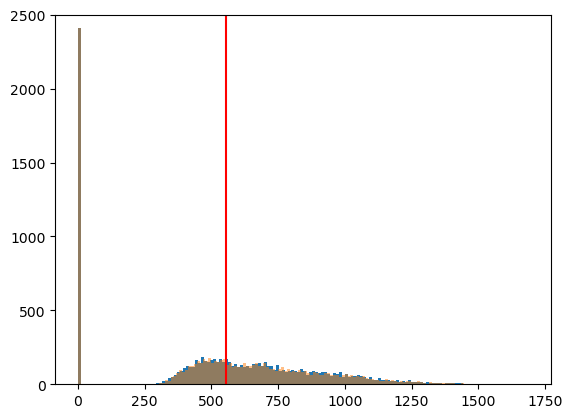

In [407]:
import matplotlib.pyplot as plt
plt.hist(pred,bins=150,alpha=1)
tp = pd.read_csv('./lgb_best.csv')['Income']
for i in test[(test['Age'] < 15)].index:
    tp[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    tp[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    tp[i] = 0
for i in range(len(pred)):
    if tp[i] < 200:
        tp[i] = 0
#     elif tp[i] > 0 and tp[i] < 200:
#         tp[i] = 200
plt.hist(tp,bins=150,alpha=0.5)
# plt.hist(train['Income'],bins=50)
plt.ylim(0,2500)
plt.vlines(train['Income'].mean(),0,3000,color='red')

In [408]:
train = pd.read_csv('./open/train.csv')
print(train[(train['Income'] > 0) & (train['Income'] < 3000)]['Income'].mean())
print(np.mean([i for i in pred if i > 0]))

937.9085463972823
706.7000910504564


In [405]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=0)
sub['Income'] = pred
sub.to_csv('./lgb.csv')

In [348]:
# 앙상블해봐바 -> 534.0415276786 #  lgbm feature 4, 0.55, 0.45

# target 인코딩해봐바 bad
# 학습 제약조건 아직 적용안해봄 -> not working 등
# stacking regressor

# 2024-04-03
# grb enssemble
# 제출복원준비